# Retina Blood Vessel Kaggle using U-Net


In [1]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [2]:
images_dir ='./data-retina/train/image'
masks_dir = './data-retina/train/mask'

In [3]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [5]:
image_size=512
input_image_size=(512,512)

In [6]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [7]:
number=200

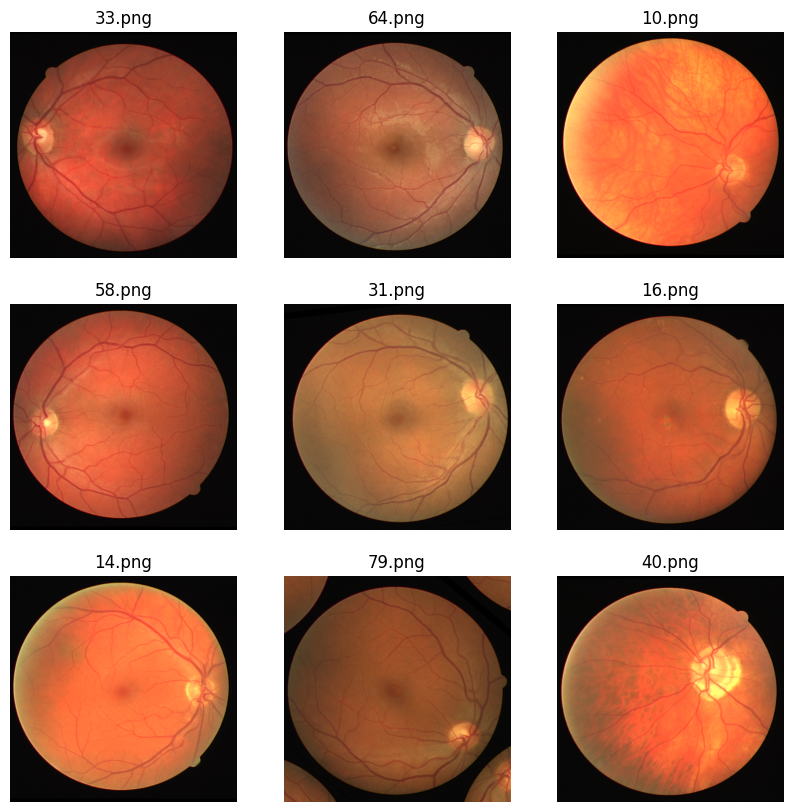

In [8]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

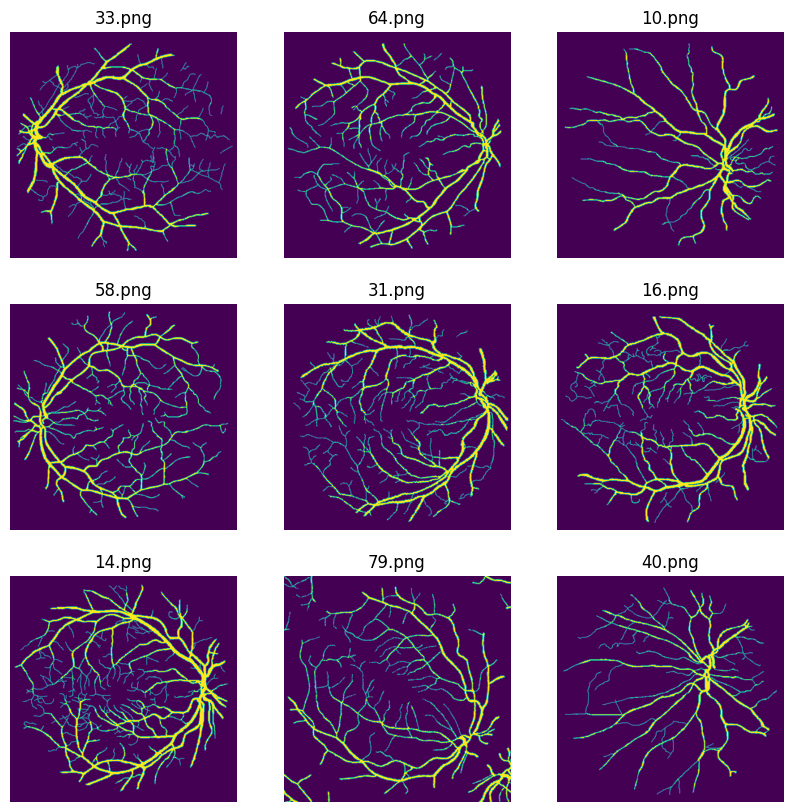

In [9]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [10]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}") 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)    
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [11]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]

(80, 512, 512, 3) (80, 512, 512, 1)


In [12]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [14]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
unet_result = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.2, batch_size = 4, epochs = 20)

Epoch 1/20
10/10 [==============================] - 476s 47s/step - loss: -108.7214 - accuracy: 0.5479 - val_loss: 5169.3335 - val_accuracy: 0.8760
Epoch 2/20
10/10 [==============================] - 429s 43s/step - loss: -259.9141 - accuracy: 0.6918 - val_loss: 9828.0918 - val_accuracy: 0.8739
Epoch 3/20
10/10 [==============================] - 444s 45s/step - loss: -302.0873 - accuracy: 0.5056 - val_loss: 5747.2944 - val_accuracy: 0.8471
Epoch 4/20
10/10 [==============================] - 447s 44s/step - loss: -332.4804 - accuracy: 0.3387 - val_loss: -1015.2784 - val_accuracy: 0.0020
Epoch 5/20
10/10 [==============================] - 459s 46s/step - loss: -363.9507 - accuracy: 0.3191 - val_loss: -134.4523 - val_accuracy: 0.3201
Epoch 6/20
10/10 [==============================] - 474s 47s/step - loss: -396.3452 - accuracy: 0.3227 - val_loss: -68.4529 - val_accuracy: 0.3489
Epoch 7/20
10/10 [==============================] - 447s 45s/step - loss: -425.5756 - accuracy: 0.3213 - val_los

In [22]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [17]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 95s 95s/step


In [18]:
len(images_test)

32

In [19]:
r1,r2,r3,r4=0.7,0.8,0.9,0.99

In [20]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

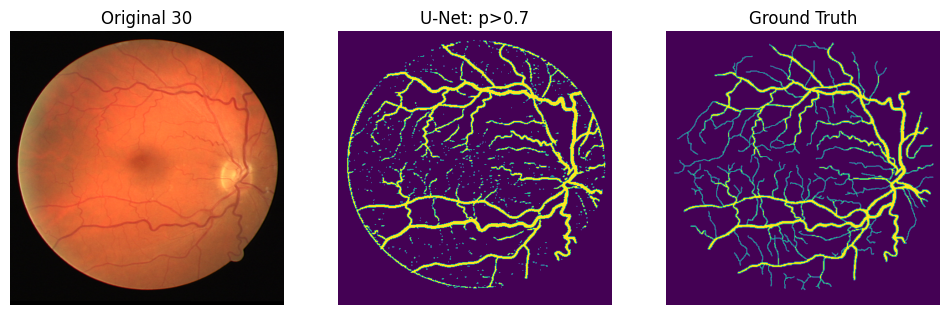

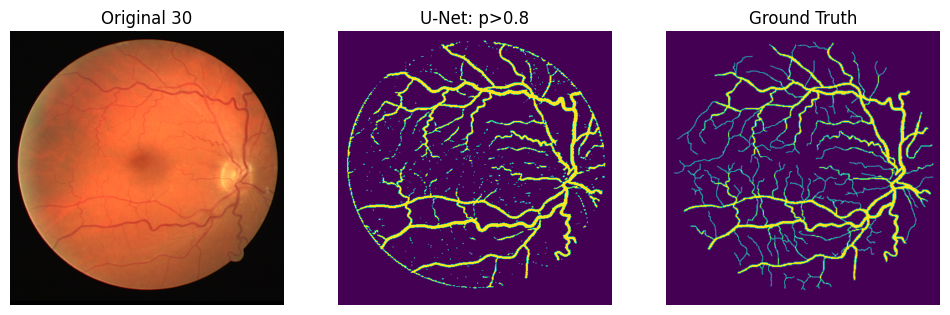

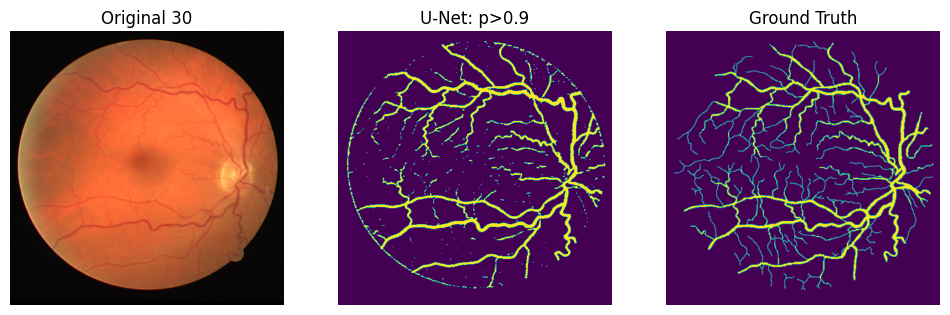

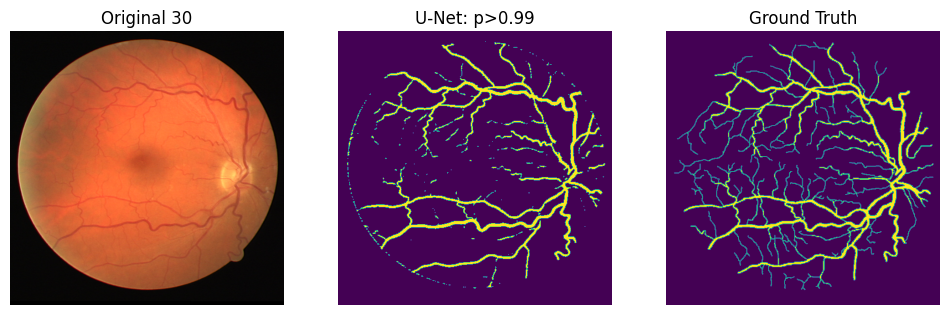

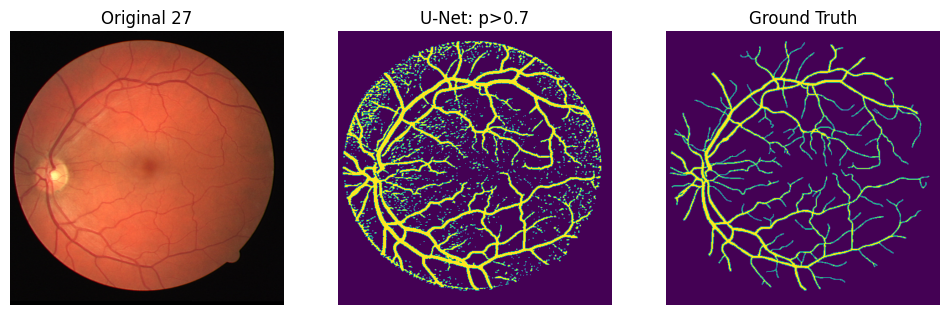

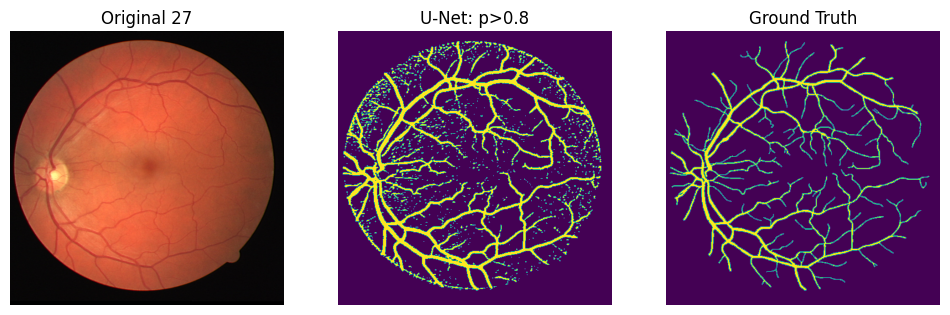

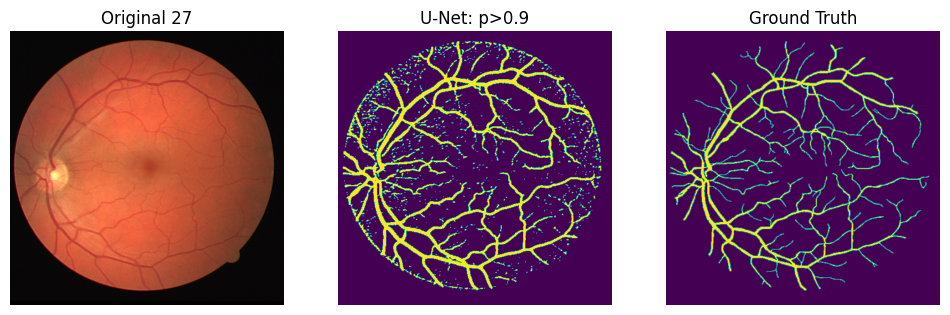

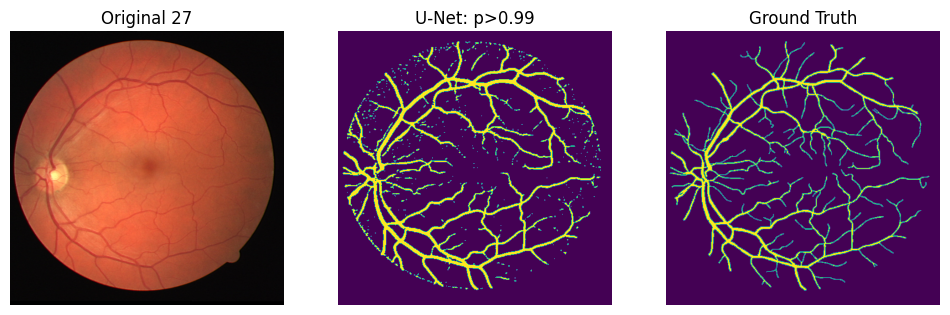

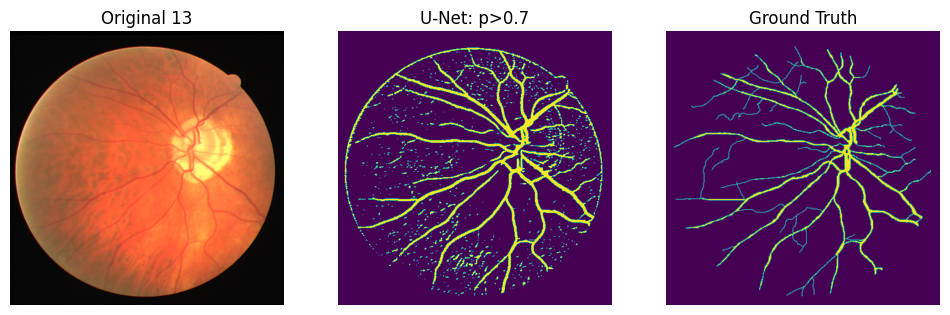

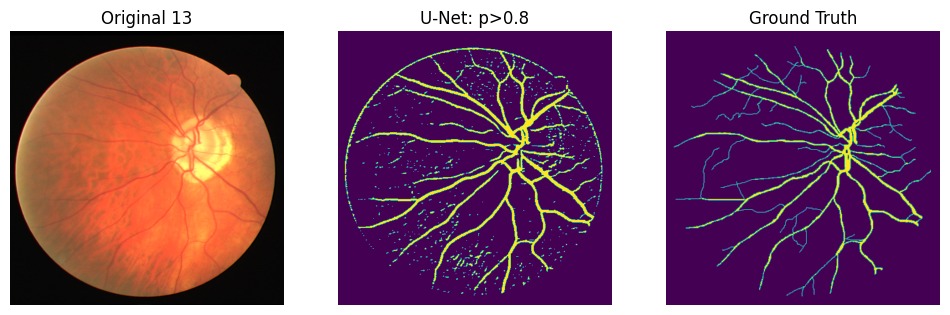

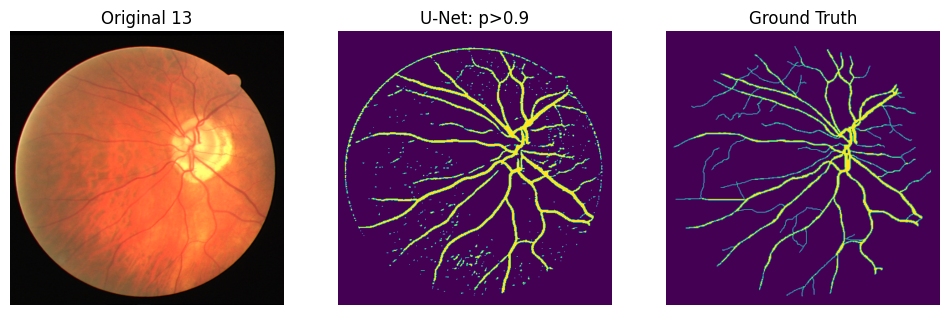

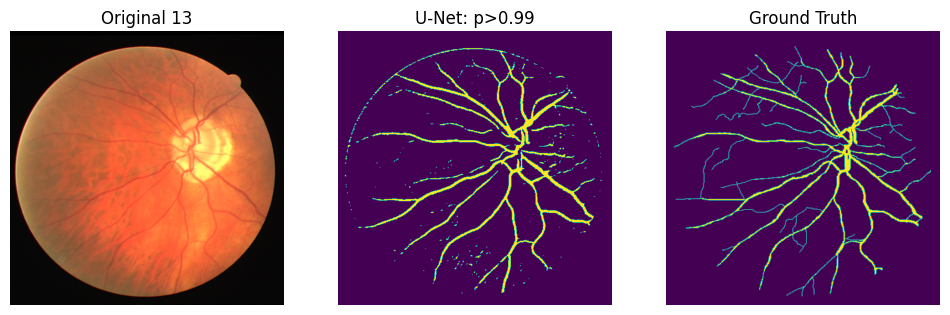

In [21]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()